# Document Scanner

In [2]:
# import packages
from pyimagesearch.transform import four_point_transform
from skimage.filters import threshold_local # need scikit-image for this
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt

%matplotlib inline

## Detect edges of the object in the image

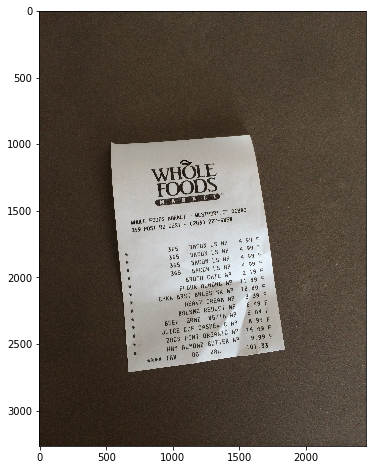

In [3]:
# load the image and clone it
image_path = "images//receipt.jpg"
image = cv2.imread(image_path) # image.shape => height(rows), width(col), channels(depth) 
orig = image.copy()

# take a look at the image before any processing
fig = plt.figure(figsize=(11,8))
plt.imshow(orig[...,::-1])
plt.show()

In order to speedup image processing, as well as make our edge detection step more accurate, we resize our scanned image to have a height of 500 pixels.

We also take special care to keep track of the ratio  of the original height of the image to the new height — this will allow us to perform the scan on the original image rather than the resized image.

Since edge detection is susceptible to noise in the image, first step is to remove the noise in the image with a 5x5 Gaussian filter

cv2.GaussianBlur is passed the following params:
 - src = input image
 - ksize = kernel size (width, heigh)
 - sigmaX = Gaussian kernel standard deviation in X direction


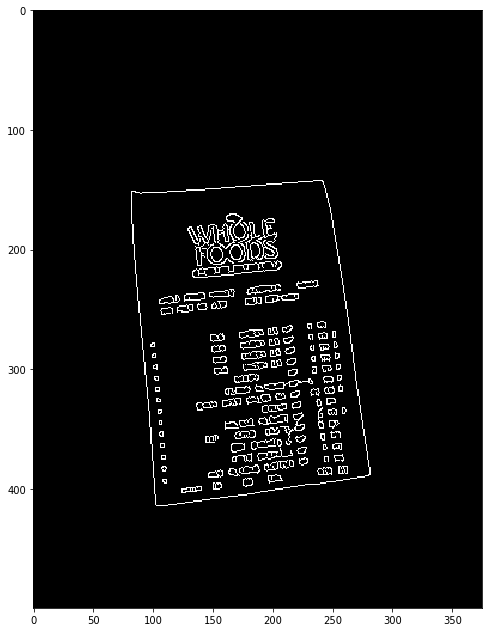

In [4]:
# compute the ratio of the old height to the new height, 
# and resize the image
ratio = image.shape[0] / 500.0 # new_height=500
image = imutils.resize(image, height=500)

# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(src=gray, ksize=(5, 5), sigmaX=0)
edged = cv2. Canny(image=gray, threshold1=75, threshold2=200)

# show edge detected image
fig = plt.figure(figsize=(11,11))
plt.imshow(edged, cmap ='gray')

plt.show()

## Finding Contours
The assumption to follow is the largest object in the image with __four corners__ is the document we intend to scan.

_Why four corners?_ 
Because it's a document scanner.

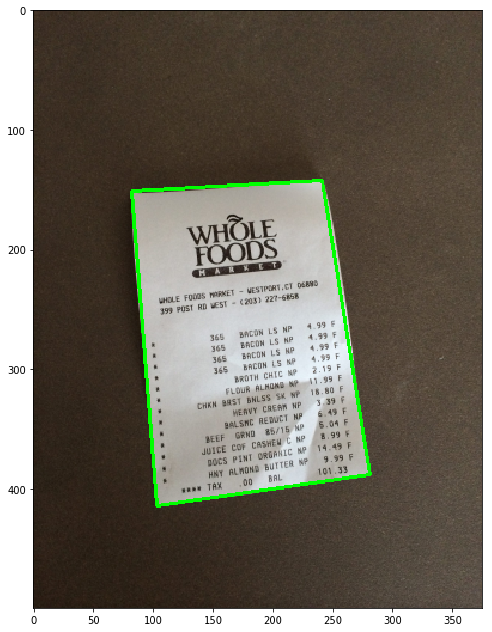

In [21]:
# find the contours in the edged image, keeping only the largest ones
# and initialize the screen contour
contours = cv2.findContours(image = edged.copy(), mode = cv2.RETR_LIST, 
                             method = cv2.CHAIN_APPROX_SIMPLE)

contours = imutils.grab_contours(contours)

# sort contours by are keyy only the 4 largest ones
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
for c in contours:
    # approximate the contour
    peri = cv2.arcLength(curve=c, closed=True) # Calculates a contour perimeter
    
    approx = cv2.approxPolyDP(curve=c, epsilon= 0.02 * peri, closed=True)
    
    # if our approximated contour has four points,
    # we can assume we have found or screen
    if len(approx) == 4:
        screenCnt = approx
        break
        
# show the contour of the doc
fig = plt.figure(figsize=(11,11))
cv2.drawContours(image=image, contours=[screenCnt], 
                 contourIdx=-1, color=(0,255,0), thickness=2)
plt.imshow(image[...,::-1])
plt.show()

__lines 14-16 above:__ to understand this, suppose you are trying to find a square in an image, but due to some problems in the image, you didn't get a perfect square, but a "bad shape" (As shown in first image below). Now you can use this function to approximate the shape. In this, second argument is called epsilon, which is maximum distance from contour to approximated contour. It is an accuracy parameter. A wise selection of epsilon is needed to get the correct output.

__line 26 above:__ : drawContours expects array (list in case of python) of contours,  not just one numpy array (which is returned from approxPolyDP). Therefore, '[screenCnt]' is passed instead of simple 'screeCnt'
- _contourIdx : Parameter indicating a contour to draw. If it is negative, all the contours are drawn._

## Apply Perspective transform & Threshold

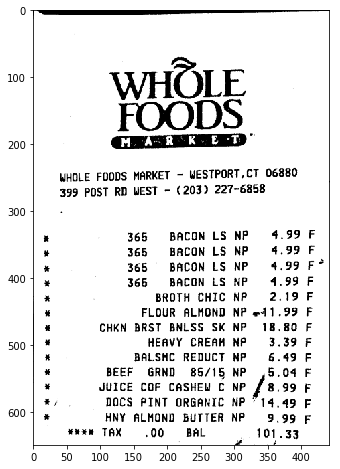

In [20]:
# apply the four point transform to obtain a top-down
#view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4,2) * ratio)

# covert the wraped image to grayscale, then threshold it
# to give it 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(image=warped, block_size=101, 
                    offset=10, method="gaussian")
warped = (warped > T).astype("uint8")*255

# show scanned image
fig = plt.figure(figsize=(11,8))
plt.imshow(imutils.resize(warped, height=650), cmap='gray')
plt.show()

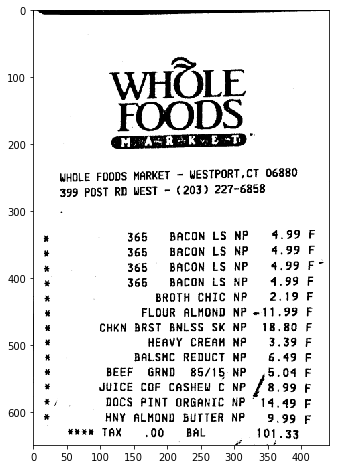

In [7]:
# show scanned image
fig = plt.figure(figsize=(11,8))
plt.imshow(imutils.resize(warped, height=650), cmap='gray')
plt.show()